In [1]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, math, random
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import pybloom
import csv
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

# Basic Information About the Experiment
Monday,Friday,Saturday (Special) (blocks of 4)

Sunday,Tuesday,Wednesday,Thursday (Normal) (blocks of 6)

Normal: The experiment ran fine through the 6th assignment, the 7th assignment should be removed

In [2]:
experiment_days = []
for row in db_engine.execute(text("""\
SELECT * from experiment_actions WHERE experiment_id = 9 ORDER BY created_at ASC
""")):
    assignment = dict(row)
    metadata = json.loads(assignment['metadata_json'])
    assignment['condition'] = metadata['condition']
    assignment['valid'] = True
    assignment['arm'] = metadata['arm']
    experiment_days.append(assignment)
    
print("Experiment first day:{0}".format(experiment_days[0]['created_at']))
print("Experiment last day:{0}".format(experiment_days[-1]['created_at']))

Experiment first day:2017-07-31 07:03:51
Experiment last day:2017-09-06 07:00:12


/home/nathan/3venv/lib/python3.5/site-packages/sqlalchemy/dialects/mysql/base.py:2513: Warning: '@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead
  cursor.execute('SELECT @@tx_isolation')


In [3]:
earliest_date = experiment_days[0]['created_at']

In [4]:
## INVALIDATE THE SEVENTH ASSIGNMENT IN THE NORMAL CONDITION
[x for x in experiment_days if x['condition']=='normal'][6]['valid']=False

## INVALIDATE THE FIFTH AND SIXTH ASSIGNMENTS IN THE SEVENTH CONDITION
[x for x in experiment_days if x['condition']=='special'][4]['valid']=False
[x for x in experiment_days if x['condition']=='special'][5]['valid']=False

experiment_dates = [x['created_at'] for x in experiment_days if x['valid']==True]

In [ ]:
#experiment_dates[-1] + datetime.timedelta(hours=24)
for edate in experiment_days:
    print("{0}: {1}".format(edate['valid'], edate['created_at']))

True: 2017-07-31 07:03:51
True: 2017-08-01 07:00:30
True: 2017-08-02 07:00:31
True: 2017-08-03 07:00:25
True: 2017-08-04 07:00:13
True: 2017-08-05 07:00:17
True: 2017-08-06 07:00:16
True: 2017-08-07 07:00:13
True: 2017-08-08 07:00:43
True: 2017-08-09 07:00:45
False: 2017-08-10 07:00:13
False: 2017-08-11 07:00:14
False: 2017-08-12 07:00:13
True: 2017-08-17 07:00:13
True: 2017-08-18 07:00:13
True: 2017-08-19 07:00:19
True: 2017-08-20 07:00:20
True: 2017-08-21 07:00:12
True: 2017-08-22 07:00:12
True: 2017-08-23 07:00:20
True: 2017-08-24 07:00:13
True: 2017-08-25 07:00:25
True: 2017-08-26 07:00:13
True: 2017-08-27 07:00:12
True: 2017-08-28 07:00:13
True: 2017-08-29 07:00:12
True: 2017-08-30 07:00:13
True: 2017-08-31 07:00:14
True: 2017-09-01 07:00:18
True: 2017-09-02 07:00:12
True: 2017-09-03 07:00:13
True: 2017-09-04 07:00:12
True: 2017-09-05 07:00:13
True: 2017-09-06 07:00:12


# Load Data about User Political Participation on Reddit
Data processed in "Classify User Politics At Beginning of Experiment"

In [75]:
user_politics_participation = {}
with open("outputs/user_politics-2017.01-07_2017.11.csv", "r") as f:
    for row in csv.DictReader(f):
        for key in row.keys():
            if key=='author':
                continue
            if row[key]=='None' or row[key] == '':
                row[key] = None
            elif key.find("observations")>-1:
                row[key] = int(row[key])
            else:
                row[key] = float(row[key])
                
        user_politics_participation[row['author']] = row
print("Loaded {0} users' political participation on reddit".format(len(user_politics_participation)))

Loaded 147569 users' political participation on reddit


## Collect Submissions

In [ ]:
submissions = {}
for row in db_engine.execute(text("""\
SELECT * FROM posts WHERE subreddit_id='2cneq' AND created_at >= '{0}' AND created_at < '{1}' ORDER BY created_at ASC
""".format(
            experiment_dates[0].isoformat(), 
            (experiment_dates[-1] + datetime.timedelta(hours=24)).isoformat()
        ))):
    submissions[row['id']] = dict(row)
print("Collected {0} submissions from the database".format(len(submissions)))
post_data_keys = list(json.loads(list(submissions.values())[0]['post_data']).keys())

Collected 27898 submissions from the database


In [ ]:
### LOAD ADDITIONAL SUBMISSIONS FROM 
post_files = []
politics_posts = {}
posts_added = 0
for filename in glob.glob("/home/nathan/reddit_archive/03.2017/posts/*.2017.*.json"):
    f = os.path.basename(filename)
    f_str = f.split(".")
    month = f_str[2]
    ## include all posts from July onward
    if(int(month) >= 7):
        post_files.append(f)
        file_object = open(filename, "r")
        for line in file_object:
            if(line.find("2cneq")>-1):
                post = json.loads(line)
                if(post['subreddit_id']=="t5_2cneq" and post['id'] not in submissions.keys()):
                    post['created'] = datetime.datetime.fromtimestamp(float(post['created_utc']))
                    post['created_at'] = datetime.datetime.fromtimestamp(float(post['retrieved_on']))
                    if post['created'] < experiment_dates[-1]:
                        submissions[post['id']] = post
                        posts_added += 1
        file_object.close()
print("Added {0} posts from Baumgartner's data to the dataset. Many of these may have been auto-removed by reddit.".format(posts_added))

Added 53577 posts from Baumgartner's data to the dataset. Many of these may have been auto-removed by reddit.


## Collect Comments
(note that we collect all comments up to 30 days after the experiment ended.

In [ ]:
comments = []
for row in db_engine.execute(text("""\
SELECT * FROM comments WHERE subreddit_id='2cneq' AND created_at >= '{0}' AND created_at < '{1}' ORDER BY created_at ASC
""".format(
            experiment_dates[0].isoformat(), 
            (experiment_dates[-1] + datetime.timedelta(days=31)).isoformat()
        ))):
    comments.append(dict(row))

In [ ]:
#experiment_dates[-1] + datetime.timedelta(days=46)
experiment_dates[-1]

In [ ]:
#comments_per_day = Counter([(x['created_at'] - experiment_dates[0]).days for x in comments])
#plt.hist([(x['created_at'] - experiment_dates[0]).days for x in comments], bins=len(comments_per_day))

### Associate Submissions and Comments with Assignments

In [ ]:
for comment in comments:
    metadata = json.loads(comment['comment_data'])
    for key in metadata.keys():
        if key not in comment.keys():
            comment[key] = metadata[key]
        else:
            comment['_'+key] = metadata[key]


In [ ]:
## THIS IS DEFINED BEFORE ADDING BAUMGARTNER DATA TO AVOID PROBLEMS RELATED TO
## KEY ORDER NOT BEING GUARANTEED
#post_data_keys = list(json.loads(list(submissions.values())[0]['post_data']).keys())

In [ ]:
for item in submissions.values():
    if("post_data" in item.keys()):
        metadata = json.loads(item['post_data']) 
    else:
        metadata = {}
        for key in post_data_keys:
            metadata[key] = None
    for key in post_data_keys:
        if key not in item.keys():
            if key in metadata:
                item[key] = metadata[key]
            else:
                item[key] = None
        else:
            item['_'+key] = metadata[key]

In [174]:
date_pointer = 0
treatment_day = experiment_days[date_pointer]
for item in sorted(submissions.values(), key=lambda x: x['created']):
    item['valid'] = True
    item['day.type'] = None
    item['TREAT']  = None
    item['minutes.to.treatment.end'] = None
    item['treatment_day'] = None
    item['TREAT.day.id']= None
    
    if(item['created'] > treatment_day['created_at'] + datetime.timedelta(hours=24)):
        print()
        print("iterating from {0} for submission on {1}".format(treatment_day['created_at'], item['created']))
        date_pointer += 1
        treatment_day = experiment_days[date_pointer]
        print("iterating to {0}...".format(treatment_day['created_at']))
        #sys.stdout.write(".")
        #sys.stdout.flush()
    if(item['created'] < treatment_day['created_at']):
        item['valid']  = False
        sys.stdout.write("x")
        continue
    if(item['created'] > experiment_days[-1]['created_at'] + datetime.timedelta(hours=24)):
        item['valid']  = False
        sys.stdout.write("X")
        continue
        
        
    item['treatment_day'] = treatment_day
    item['valid']  = treatment_day['valid']
    item['day.type']  = treatment_day['condition']
    item['TREAT']  = treatment_day['arm']
    item['TREAT.day.id'] = date_pointer
    item['minutes.to.treatment.end'] = ((treatment_day['created_at'] + datetime.timedelta(hours=24)) - 
                                        item['created']).total_seconds() / 60

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [176]:
#list(submissions.values())[-1]

In [ ]:
#plt.hist([x['minutes.to.treatment.end'] for x in submissions.values() if x['valid'] and x['minutes.to.treatment.end']>0])
plt.hist([x['minutes.to.treatment.end'] for x in submissions.values() if x['valid']])
plt.title("Minutes to Treatment End")

### Load Moderation Log Going Back to Earliest Experiment Date

In [ ]:
recent_mod_actions = []
for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="2cneq" AND created_utc >= "{0}" ORDER BY created_utc;'.format(earliest_date))):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

In [ ]:
item

### Assign Moderation Actions to Submissions and Comments

In [ ]:
from collections import defaultdict, Counter
mod_comment_actions = defaultdict(list)
mod_submission_actions = defaultdict(list)
approved_count = 0
removed_count = 0
submission_approved_count = 0
submission_removed_count = 0
total_coments_removed_at_least_once = []
comments_with_mod_actions = set()

total_submissions_removed_at_least_once = []
submissions_with_mod_actions = set()


for action in recent_mod_actions:
    if action['action'] == "removecomment" or action['action'] == "approvecomment":
        comment_id = action['target_fullname'].replace("t1_", "")
        mod_comment_actions[comment_id].append(action)
        comments_with_mod_actions.add(action['target_fullname'])
    elif action['action'] == 'removelink' or action['action'] == 'approvelink':
        submission_id = action['target_fullname'].replace("t3_", "")
        mod_submission_actions[submission_id].append(action)
        submissions_with_mod_actions.add(action['target_fullname'])
        

print("{0} Total Comment moderation actions".format(sum([len(x) for x in mod_comment_actions.values()])))
print("{0} Comments with moderation actions".format(len(mod_comment_actions)))
print("{0} Comments with more than one mod action".format(len([x for x in mod_comment_actions.values() if len(x)>1])))
print("")

print("{0} Total Submission moderation actions".format(sum([len(x) for x in mod_submission_actions.values()])))
print("{0} Submissions with moderation actions".format(len(mod_submission_actions)))
print("{0} Submissions with more than one mod action".format(len([x for x in mod_submission_actions.values() if len(x)>1])))
print("")

                                                          

for comment in comments:
    comment['visible'] = True
    if comment['id'] in mod_comment_actions.keys():
        for action in mod_comment_actions[comment['id']]:
            if action['action'] =="removecomment":
                removed_count += 1
                total_coments_removed_at_least_once.append(comment['id'])
                comment['visible'] = False
            elif action['action'] == "approvecomment":
                approved_count += 1
                comment['visible']  = True

print("Summary of Comment Visibility:")
print(Counter([x['visible'] for x in comments]))
print("Took {0} actions to set a comment to removed".format(removed_count))
print("Took {0} actions to set a comment to approved".format(approved_count))
print("")                                                 
                                                          
for item in submissions.values():
    item['visible'] = True
    if item['id'] in mod_submission_actions.keys():
        for action in mod_submission_actions[item['id']]:
            if action['action'] =="removelink":
                submission_removed_count += 1
                total_submissions_removed_at_least_once.append(item['id'])
                item['visible'] = False
            elif action['action'] == "approvelink":
                submission_approved_count += 1
                item['visible']  = True

print("Summary of Submission Visibility:")
print(Counter([x['visible'] for x in submissions.values()]))
print("Took {0} actions to set a submission to removed".format(submission_removed_count))
print("Took {0} actions to set a comment to approved".format(submission_approved_count))
                                                   

### Associate Submissions with Comments from the Experiment

In [ ]:
post_comments = defaultdict(list)
for comment in comments:
    post_comments[comment['link_id']].append(comment)

print("{0} comments associated with {1} posts out of {2} comments".format(
    sum([len(x) for x in post_comments.values()]),
    len(post_comments),
    len(comments)))
## ADD COMMENT COUNTS TO SUBMISSIONS
for key, submission in submissions.items():
    submission_id = "t3_" + key
    if(submission_id in post_comments.keys()):
        submission['num.comments'] = len(post_comments[submission_id])
        submission['num.comments.removed'] = len([x for x in post_comments[submission_id] if x['visible']==False])
    else:
        submission['num.comments']  = 0
        submission['num.comments.removed'] = 0
        sys.stdout.write(".")

In [ ]:
#Counter([x['day.type'] for x in submissions])
plt.hist([math.log1p(x['num.comments']) for x in submissions.values() if x['valid']])

### Spot Check a Random Sample of submissions that are visible and check to see how many of them are rated as visible by the Twitter platform

In [ ]:
#[y['permalink'] for y in random.sample([x for x in submissions.values() if x['valid'] and x['visible']==True], 10)]

### Set up Initial Dataframes for Submissions

In [ ]:
#submissions_df = pd.DataFrame([x for x in submissions if x['valid']])
#submissions_df['log_num_comments'] = submissions_df.apply(lambda x: math.log1p(x['num.comments']), 1)
#submissions_df['log_num_comments_removed'] = submissions_df.apply(lambda x: math.log1p(x['num.comments.removed']), 1)
#submissions_df['day_type'] = submissions_df['day.type']

## Assign Treatments to Comments in the Dataset

In [ ]:
experiment_comments = []
with open("sticky_comment_power_analysis_2cneq_7.2017_9.2017_comments.csv", "r") as f:
    for row in csv.DictReader(f):
        experiment_comments.append(row)
print("Loaded {0} experiment comments".format(len(experiment_comments)))

In [ ]:
comments_per_day = Counter([(parser.parse(x['created.utc']).replace(tzinfo=None) - experiment_dates[0]).days for x in experiment_comments])
plt.hist([(parser.parse(x['created.utc']).replace(tzinfo=None) - experiment_dates[0]).days for x in experiment_comments], bins=len(comments_per_day))

In [ ]:
experiment_comments = sorted(experiment_comments, key=lambda x: x['created.utc'])

In [ ]:
#submission_ids = {}
#i = 0
#for submission in submissions:
#    submission_ids[submission['id']] = i

#unmatched_submissions = set()

date_pointer = 0
treatment_day = experiment_days[date_pointer]
matched_submissions = 0 

newcomer_accounts = set()

for item in experiment_comments:
    item['matched.treatment'] = False
    item['day.type'] = None
    item['valid.treatment'] = False
    item['TREAT'] = None
    item['TREAT.day.id'] = None
    item['minutes.to.treatment.end'] = None
    item['submission.matched'] = False
    item['submission.created'] = None
    item['submission.same.treatment'] = False
    item['submission.day.type'] = None
    item['submission.TREAT.day.id'] = None
    item['submission.minutes.to.treatment.end'] = None
    item['created'] = parser.parse(item['created.utc']).replace(tzinfo=None)
    item['post.visible'] = None
    submission = None
    
    submission_id = item['post.id'].replace("t3_", "")
    if(submission_id in submissions.keys()):
        matched_submissions += 1
        submission = submissions[submission_id]
        item['submission.created'] = submission['created']
        item['post.visible'] = submission['visible']
        item['submission.matched'] = True
        if(isinstance(item['post.visible'],  str)):
            item['post.visible'] == item['post.visible'] =='True'
        if("TREAT.day.id" in submission.keys()):
            item['submission.TREAT.day.id'] = submission['TREAT.day.id']
        item['submission.day.type'] = submission['day.type']
        item['submission.minutes.to.treatment.end'] = submission['minutes.to.treatment.end']
    
    if(treatment_day is not None):
        if(item['created'] > treatment_day['created_at'] + datetime.timedelta(hours=24)):
            print("iterating from {0} for submission on {1}".format(treatment_day['created_at'], item['created']))
            date_pointer += 1
            if(date_pointer >= len(experiment_days)):
                treatment_day = None
                continue
            else:
                treatment_day = experiment_days[date_pointer]
            print("iterating to {0}...".format(treatment_day['created_at']))
            #sys.stdout.write(".")
            #sys.stdout.flush()
        if(item['created'] < treatment_day['created_at']):
#            item['matched.treatment']  = False
#            sys.stdout.write("x")
            continue
        if(item['created'] > experiment_days[-1]['created_at'] + datetime.timedelta(hours=24)):
#            item['matched.treatment']  = False
#            sys.stdout.write("X")
            continue
            
        item['matched.treatment'] = True
        if(item['author.prev.comments']=='0'):
            newcomer_accounts.add(item['author'])

    #    item['treatment_day'] = treatment_day
        item['valid.treatment']  = treatment_day['valid']
        item['day.type']  = treatment_day['condition']
        item['TREAT']  = treatment_day['arm']
        item['TREAT.day.id'] = date_pointer
        item['minutes.to.treatment.end'] = ((treatment_day['created_at'] + datetime.timedelta(hours=24)) - 
                                            item['created']).total_seconds() / 60
#        if(submission is not None):
#            item['submission.same.treatment']  = (item['TREAT.day.id'] == submission['TREAT.day.id'] )

### Validate Fields in Comments and Submissions Datasets

In [ ]:
## THESE ARE COMMENTS MADE DURING THE EXPERIMENT THAT DON'T HAVE A MATCHED POST
## PROBABLY BECAUSE THEY WERE MADE ON VERY OLD SUBMISSIONS
print("Comments in the experiment that don't have a matched submission")
print(Counter([(x['TREAT']!=None and x['submission.matched'] ==False) for x in experiment_comments]))
print()
print("Comments in the experiment that DO have a matched submission")
print(Counter([(x['TREAT']!=None and x['submission.matched'] ==True) for x in experiment_comments]))

In [ ]:
#experiment_comments[0]

In [ ]:
# Counter(
#     [z['post.id'] for z in 
#      [x for x in experiment_comments if (x['TREAT']!=None and x['submission.matched'] ==False)]])

In [ ]:
plt.hist([math.log1p(int(x['minutes.to.treatment.end'])) for x in experiment_comments if x['valid.treatment']])

In [ ]:
#experiment_comments[0]

In [ ]:
#print("Matched Treatment: {0}".format(Counter([x['matched.treatment'] for x in experiment_comments])))
#print("Matched & Valid Treatment: {0}".format(Counter([x['matched.treatment'] and x['valid.treatment'] for x in experiment_comments])))
#print("Submission Same Treatment: {0}".format(Counter([x['TREAT.day.id'] == x['submission.TREAT.day.id'] and x['TREAT.day.id']!=None for x in experiment_comments])))
print("Newcomer Authors: {0}".format(len(newcomer_accounts)))
#print("Matched Submissions: {0}".format(matched_submissions))

### Check Missing Submissions from Comment Dataset

In [ ]:
missing_submission_ids = set()
comments_missing_submission = []
for item in experiment_comments:
    if(item['TREAT']!=None and item['submission.matched']!=True):
        missing_submission_ids.add(item['post.id'])
        comments_missing_submission.append(item)
print("{0} submission IDs are missing from {1} comments".format(len(missing_submission_ids), 
                                                                len(comments_missing_submission)))

In [ ]:
#random.sample(missing_submission_ids, 10)

A random sample of these submission IDs finds that all of the ones checked are from before the experiment period, or during the period when the experiment was inactive.

### Create Newcomer Dataset

In [ ]:
newcomer_comments = defaultdict(list)
comments_by_newcomers = 0

DAY_INTERVAL_IN_SECONDS = 15*24*60*60


for comment in experiment_comments:
    if(comment['author'] in newcomer_accounts):
        newcomer_comments[comment['author']].append(comment)
        comments_by_newcomers+=1
print("Added {0} comments for {1} newcomers".format(comments_by_newcomers, len(newcomer_comments)))

experiment_newcomers = []

newcomer_later_comments = defaultdict(list)

for comment_list in newcomer_comments.values():
    newcomer = {"num.comments": 0,
                "num.comments.removed": 0}
    first_comment = comment_list[0]
    for key in ['TREAT', 'TREAT.day.id', 'day.type', 'post.author', 'toplevel', 'visible',
                'post.id', 'post.visible', 'submission.TREAT.day.id', 'submission.day.type', 
                'submission.minutes.to.treatment.end','minutes.to.treatment.end', 'matched.treatment', 'valid.treatment']:
        newcomer[key] = first_comment[key]
        
    comment_arm_count = defaultdict(int)
    for comment in comment_list:
        if(comment['id'] == first_comment['id']):
            continue
        if((comment['created']- first_comment['created']).total_seconds() > DAY_INTERVAL_IN_SECONDS):
            continue
        
        comment_arm_count[comment['TREAT']] += 1
        
        newcomer['num.comments'] +=1
        if(comment['visible']!='True'):
            newcomer['num.comments.removed'] +=1
            
        if(newcomer['num.comments']>=1 and newcomer['num.comments']<5):
            comment_object = copy.copy(comment)
            for key in newcomer.keys():
                comment_object["first."+key] = newcomer[key]
            newcomer_later_comments[newcomer['num.comments']+1].append(comment_object)
    
    for arm in ["arm_0","arm_1"]:
        if(arm in comment_arm_count.keys()):
            newcomer[arm.replace("_",".") + ".comments"] = comment_arm_count[arm]
        else:
            newcomer[arm.replace("_",".") + '.comments'] = 0

            
    ## TODO: FINISH THIS CODE
    experiment_newcomers.append(newcomer)
    
            
        

In [ ]:
#newcomer_later_comments[2][0]

### Load Data on Submission Appearance on the Front Page

In [ ]:
submissions_from_file = []
with open("sticky_comment_power_analysis_2cneq_7.2017_9.2017_posts.csv", "r") as f:
    for row in csv.DictReader(f):
        submissions_from_file.append(row)
print("Loaded {0} experiment submissions".format(len(submissions_from_file)))

# Output Data for Submissions, Comments, and Newcomers

In [ ]:
pd.DataFrame([x for x in experiment_comments if x['matched.treatment']]).to_csv("outputs/experiment.comments.10.2017.csv")

In [ ]:
pd.DataFrame([x for x in submissions.values() if x['valid']]).to_csv("outputs/experiment.submissions.10.2017.csv")

In [ ]:
pd.DataFrame(experiment_newcomers).to_csv("outputs/newcomer.comments.10.2017.csv")

In [ ]:
pd.DataFrame(newcomer_later_comments[2]).to_csv("outputs/newcomer.second.comments.10.2017.csv")
pd.DataFrame(newcomer_later_comments[3]).to_csv("outputs/newcomer.third.comments.10.2017.csv")
pd.DataFrame(newcomer_later_comments[4]).to_csv("outputs/newcomer.fourth.comments.10.2017.csv")
pd.DataFrame(newcomer_later_comments[5]).to_csv("outputs/newcomer.fifth.comments.10.2017.csv")

# Analyze Data on Scores and Downvotes Over Time for Coments in Stylesheet Experiment

### Step one: collect scores over time

In [ ]:
comment_snapshots = defaultdict(list)
for row in db_engine.execute(text("""\
    select experiment_thing_snapshots.created_at as et_created_at, 
    experiment_thing_snapshots.experiment_thing_id, 
    experiment_thing_snapshots.metadata_json as metadata_json, 
    experiment_things.object_created as created_at, 
    experiment_things.query_index as post_id
    FROM experiment_thing_snapshots JOIN experiment_things 
    ON experiment_thing_snapshots.experiment_thing_id = experiment_things.id 
    WHERE experiment_thing_snapshots.experiment_id=9 AND experiment_thing_snapshots.object_type=2 
    ORDER BY experiment_thing_snapshots.created_at ASC;
    """)):
    snapshot = {}
    for key, value in row.items():
        if(key!="metadata_json"):
            snapshot[key] = value
    metadata = json.loads(row['metadata_json'])
    for key, value in metadata.items():
        snapshot[key] = value
    comment_snapshots[snapshot['experiment_thing_id']].append(snapshot)

In [ ]:
for key, snapshots in comment_snapshots.items():
    comment_snapshots[key] = sorted(snapshots, key=lambda x: x['created_at'])

In [ ]:
experiment_comment_ids = set([x['id'] for x in experiment_comments])
comment_snapshot_ids = set(comment_snapshots.keys())
Counter([(x in experiment_comment_ids) for x in comment_snapshot_ids])

In [ ]:
i = 0
experiment_comment_index = 0
comment_indices = {}
for comment in experiment_comments:
    comment_indices[comment['id']] = experiment_comment_index
    experiment_comment_index += 1

In [ ]:
all_comment_snapshots = []
omitted_snapshots = 0
for key, snapshots in comment_snapshots.items():
    if key not in comment_indices.keys():
        omitted_snapshots += 1
        continue
    comment = experiment_comments[comment_indices[key]]

    snapshot_number = 0
    for snapshot in snapshots:
        for key in comment.keys():
            snapshot['comment.' + key] = comment[key]
        snapshot['snapshot.number'] = snapshot_number
        snapshot_number += 1
        all_comment_snapshots.append(snapshot)
print("Created snapshot dataframe with {0} snapshots, {1} omitted.".format(len(all_comment_snapshots), omitted_snapshots))

In [ ]:
pd.DataFrame(all_comment_snapshots).to_csv("outputs/comment.snapshots.10.2017.csv")

# Create a Per-Day Dataset

In [55]:
day_comments = defaultdict(list)
for comment in experiment_comments:
    if(comment['TREAT.day.id']!=None):
        day_comments[comment['TREAT.day.id']].append(comment)

In [177]:
day_submissions = defaultdict(list)
for submission in submissions.values():
    if(submission['TREAT.day.id']!=None):
        day_submissions[submission['TREAT.day.id']].append(submission)

In [185]:
#list(day_submissions.values())[3][0]

In [76]:
def user():
    return {
        "author":None,
        "left.observations":0,
        "right.observations":0,
        "donald.observations":0,
        "politics.observations":0,
        'pct.politics':None,
        'pct.donald':None,
        'pct.left': None,
        'pct.right':None,
        "item.observations":0
    }

#user_politics_participation
user_politics = defaultdict(user)
for key, item in user_politics_participation.items():
    user_politics[key] = item

In [186]:
def day_count_object():
    return {
        "num.posts":0,
        "num.comments":0,
        "num.authors":0,
        "unique.authors":set(),
        "num.comments.removed":0,
        "num.posts.removed":0,
        "comments.by.pre.study.politics":[],
        "comments.by.pre.study.left":[],
        "comments.by.pre.study.right":[],
        "comments.by.pre.study.donald":[],
        "authors.by.pre.study.politics":[],
        "authors.by.pre.study.right":[],
        "authors.by.pre.study.left":[],
        "authors.by.pre.study.donald":[],
        "TREAT.day.id":None,
        "TREAT":None,
        "day.type":None,
        "valid.treatment":None
    }
day_counts = defaultdict(day_count_object)

for day, comments in day_comments.items():
    day_count = day_counts[day]
    day_count['TREAT.day.id'] = day
    day_count['TREAT'] = comments[0]['TREAT']
    day_count['day.type'] = comments[0]['day.type']
    day_count['valid.treatment'] = comments[0]['valid.treatment']
    day_count['num.posts'] = len(day_submissions[day])
    day_count['num.posts.removed'] = len([x for x in day_submissions[day] if x['visible']!=False])

    for comment in comments:
        day_count['num.comments'] += 1        
        if(comment['visible']=='False'):
            day_count['num.comments.removed'] +=1    
        if(comment['author'] not in day_count['unique.authors']):
            day_count['num.authors'] += 1
            user_politics[comment['author']]['author'] = comment['author']
            up_author = user_politics[comment['author']]
            day_count['authors.by.pre.study.politics'].append(up_author['pct.politics'])
            day_count['authors.by.pre.study.left'].append(up_author['pct.left'])
            day_count['authors.by.pre.study.right'].append(up_author['pct.right'])
            day_count['authors.by.pre.study.donald'].append(up_author['pct.donald'])

        day_count['comments.by.pre.study.politics'].append(up_author['pct.politics'])
        day_count['comments.by.pre.study.left'].append(up_author['pct.left'])
        day_count['comments.by.pre.study.right'].append(up_author['pct.right'])
        day_count['comments.by.pre.study.donald'].append(up_author['pct.donald'])        
        
        day_count['unique.authors'].add(comment['author'])


In [189]:
#plt.hist([x['num.posts.removed'] for x in day_counts.values()])

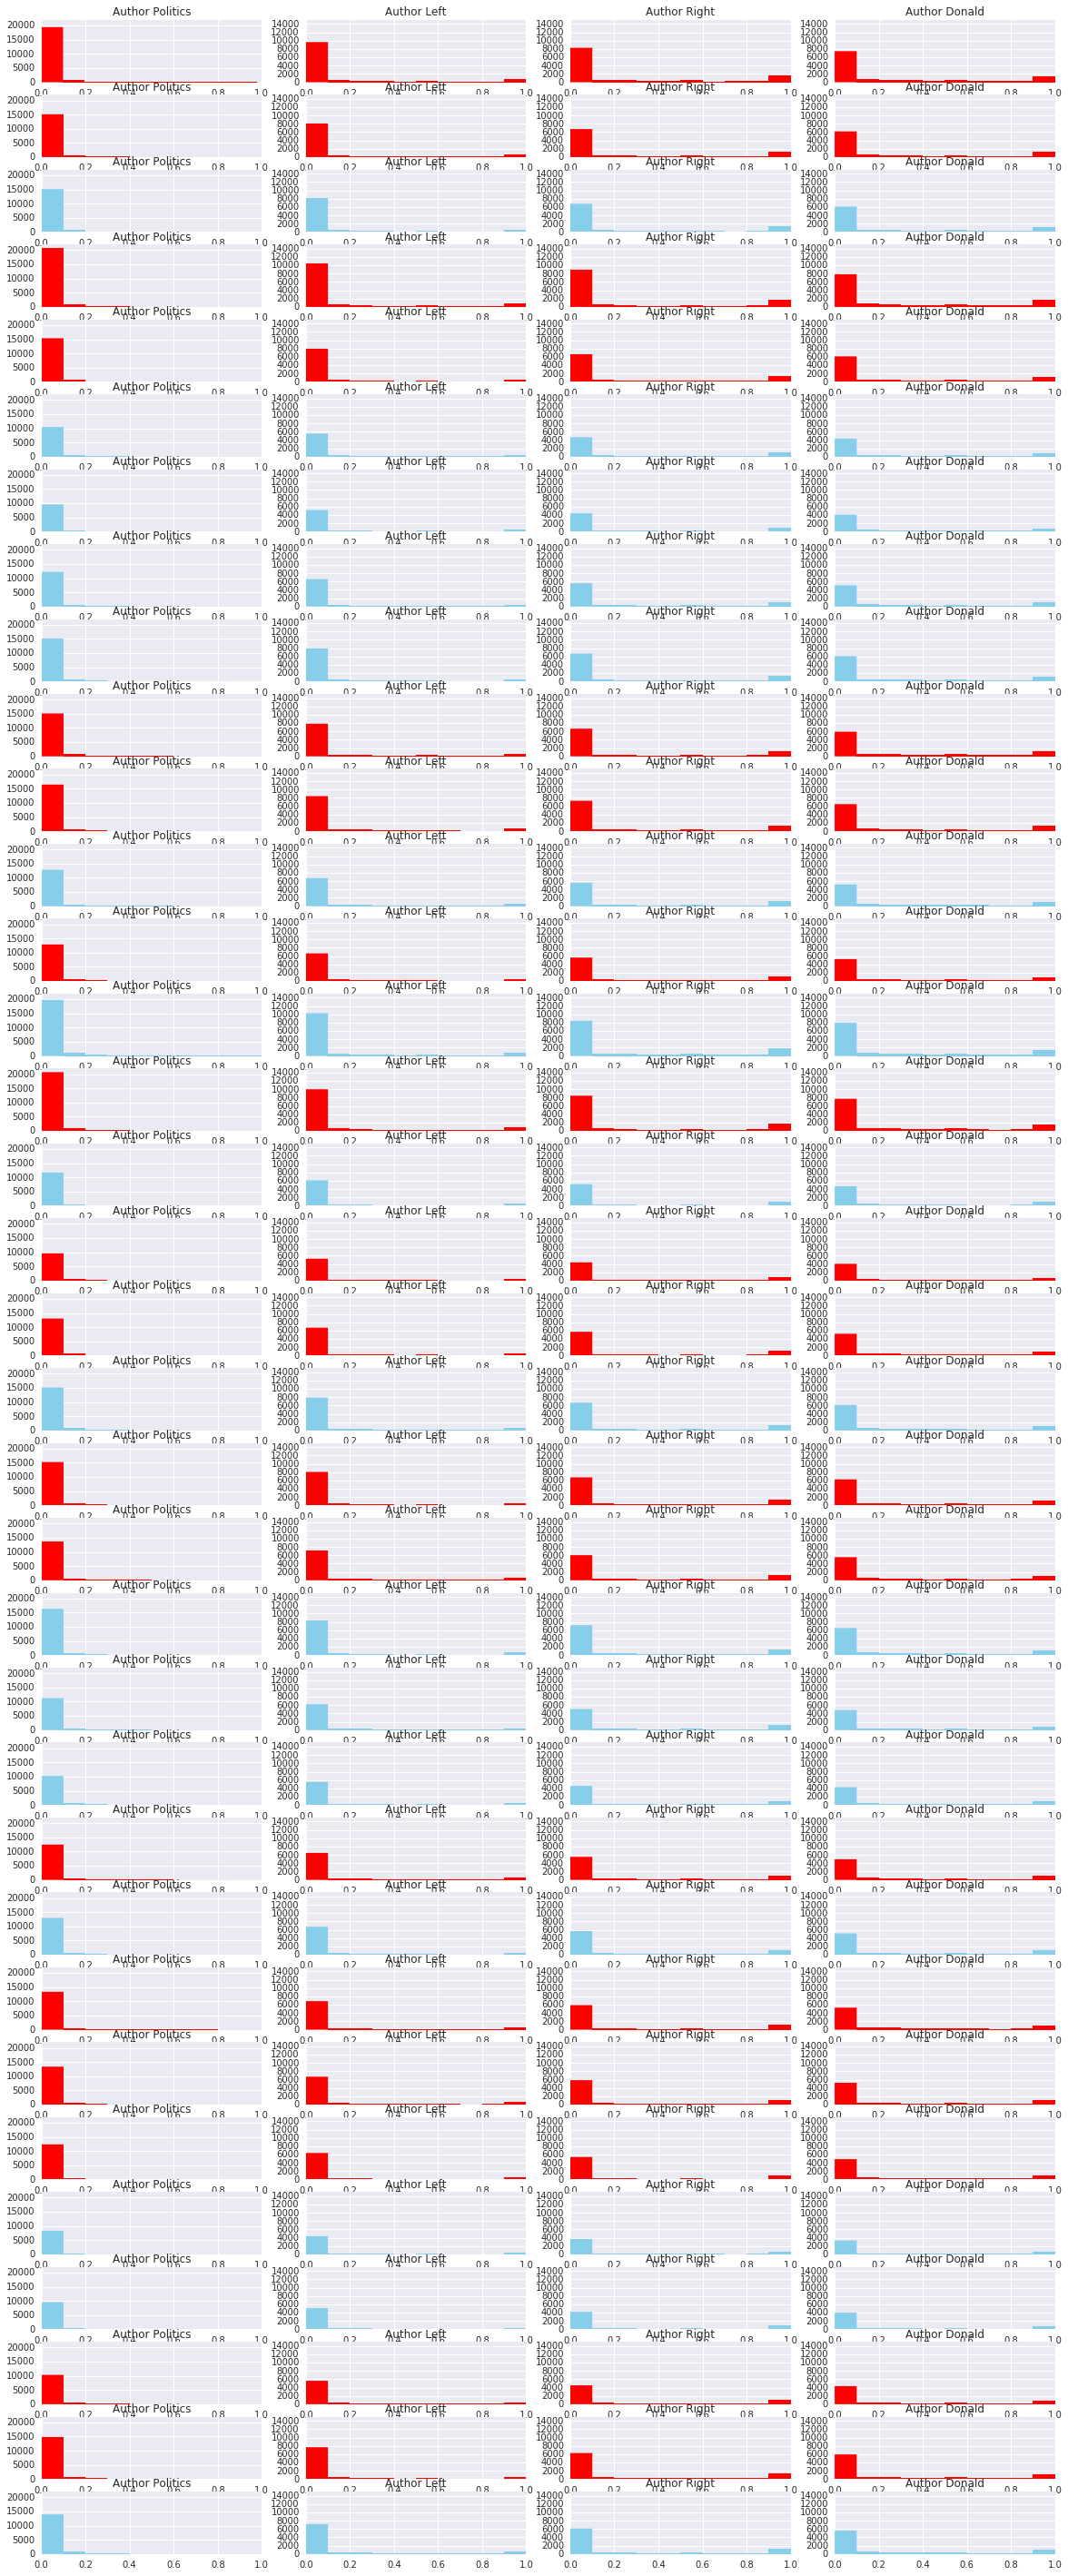

In [122]:
plt.figure(figsize=(20, 50))
i = 1
for day, day_data in list(day_counts.items()):
    color = "skyblue"
    if(day_data['TREAT']=="arm_1"):
        color="red"

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['authors.by.pre.study.politics'] if x is not None], lw=0, color=color)
    plt.ylim((0,22000))
    plt.title("Author Politics")
    i+=1

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['authors.by.pre.study.left'] if x is not None], lw=0, color=color)
    plt.ylim((0,15000))
    plt.title("Author Left")
    i+=1

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['authors.by.pre.study.right'] if x is not None], lw=0, color=color)
    plt.ylim((0,15000))

    plt.title("Author Right")
    i+=1

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['authors.by.pre.study.donald'] if x is not None], lw=0, color=color)
    plt.ylim((0,15000))
    plt.title("Author Donald")
    i+=1
    
plt.show()

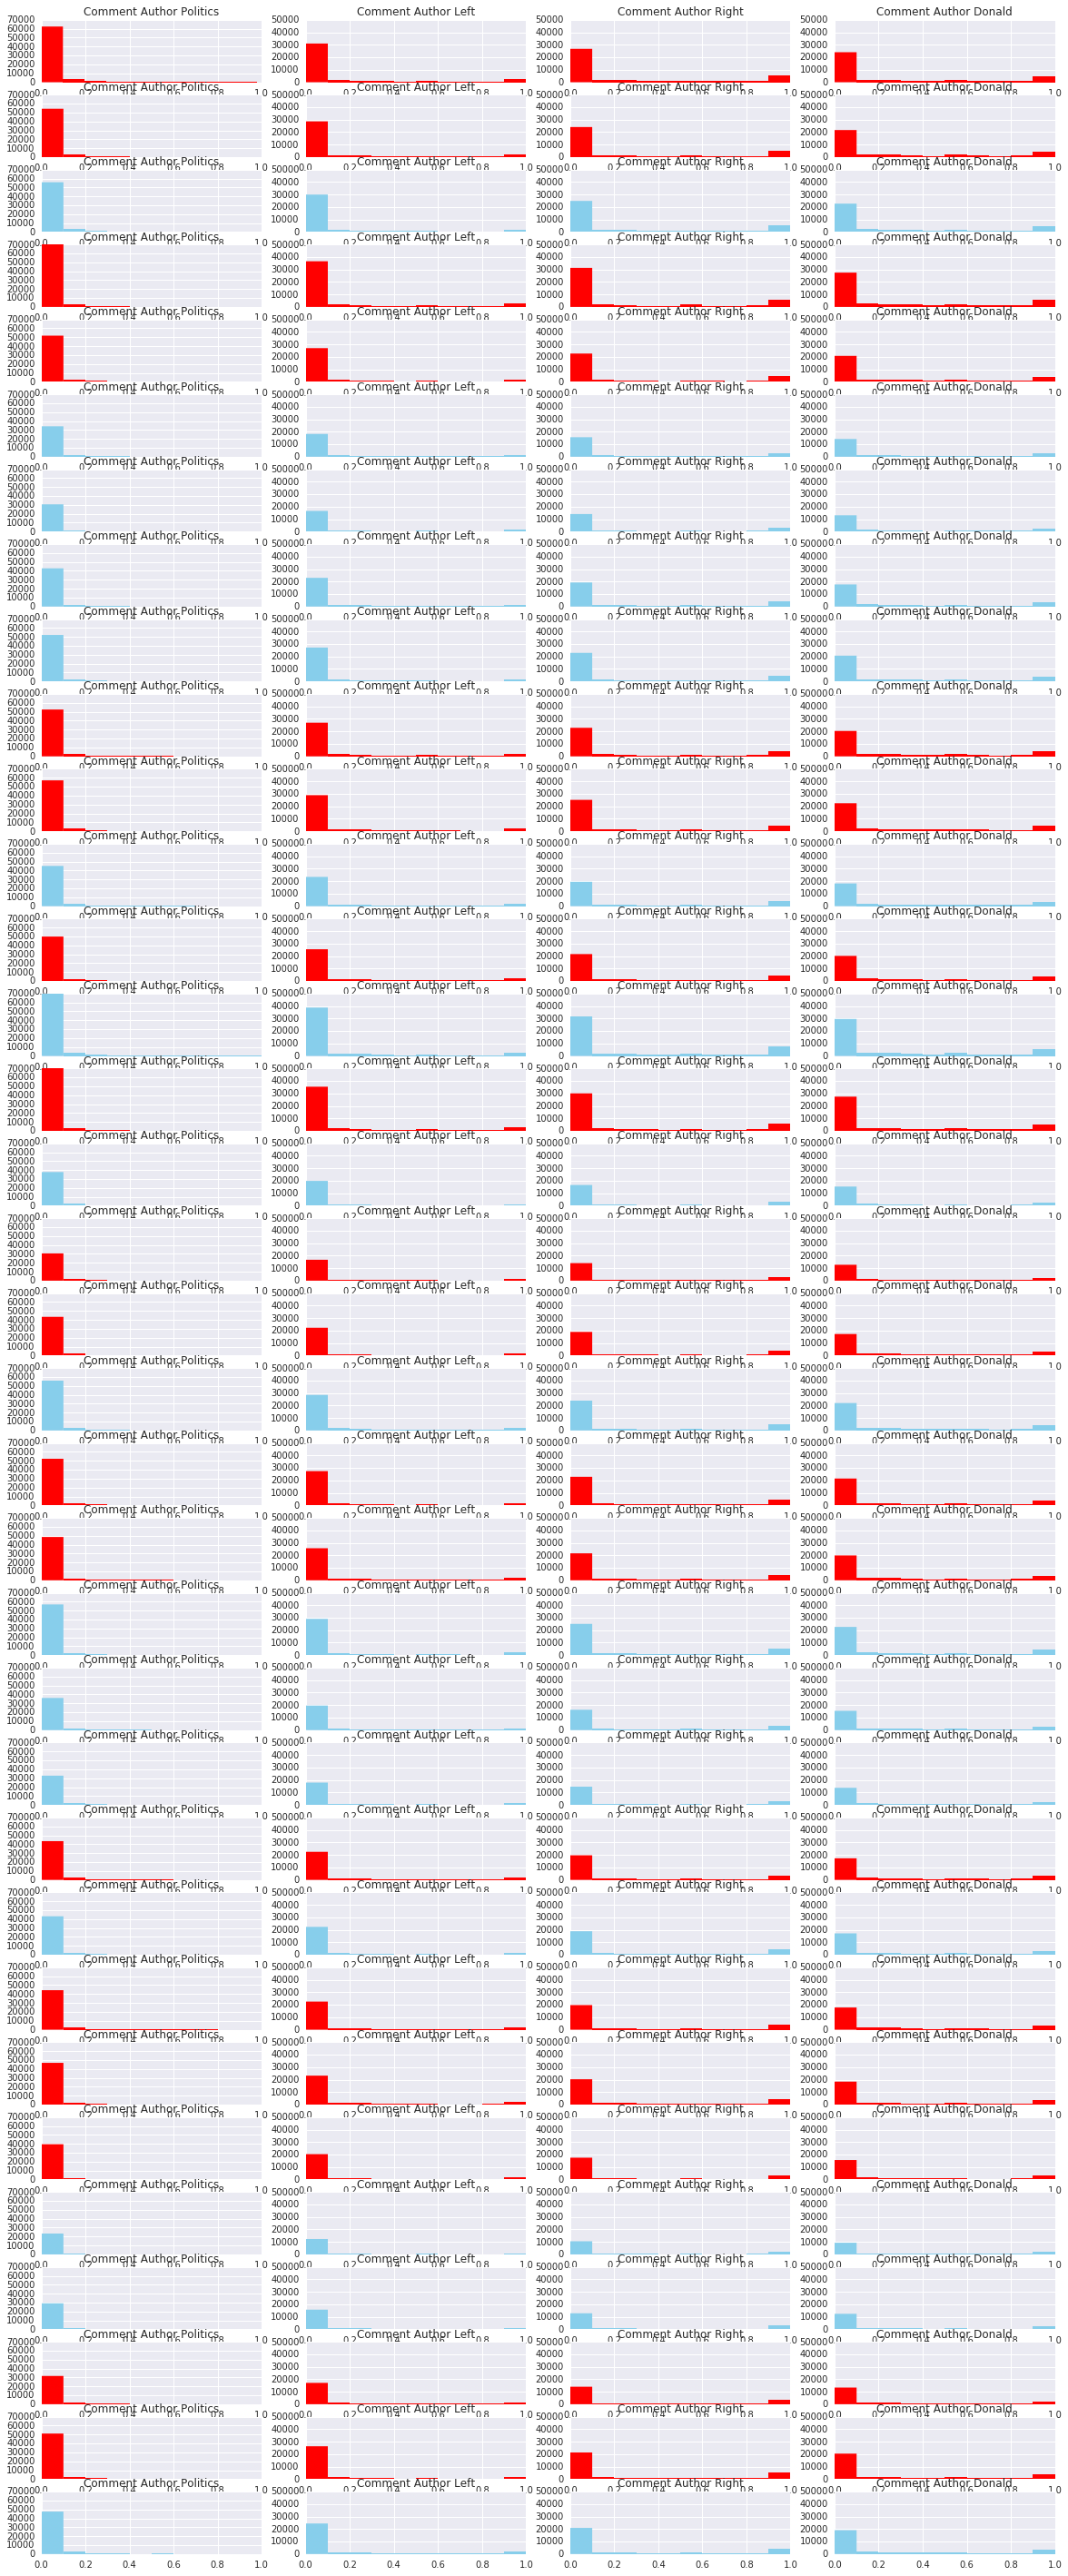

In [126]:
plt.figure(figsize=(20, 50))
i = 1
for day, day_data in list(day_counts.items()):
    color = "skyblue"
    if(day_data['TREAT']=="arm_1"):
        color="red"

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['comments.by.pre.study.politics'] if x is not None], lw=0, color=color)
    plt.ylim((0,70000))
    plt.title("Comment Author Politics")
    i+=1

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['comments.by.pre.study.left'] if x is not None], lw=0, color=color)
    plt.ylim((0,50000))
    plt.title("Comment Author Left")
    i+=1

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['comments.by.pre.study.right'] if x is not None], lw=0, color=color)
    plt.ylim((0,50000))
    plt.title("Comment Author Right")
    i+=1

    plt.subplot(len(day_counts), 4, i)
    plt.hist([x for x in day_data['comments.by.pre.study.donald'] if x is not None], lw=0, color=color)
    plt.ylim((0,50000))
    plt.title("Comment Author Donald")
    i+=1
    
plt.show()

### Create Dataset of Days
Criteria for political participation or partisanship: more than 10% of relevant comments

In [153]:
day_count_data = list()
for day, count in day_counts.items():
    list_keys = ['comments.by.pre.study.politics', 'comments.by.pre.study.right', 
                'comments.by.pre.study.left', 'comments.by.pre.study.donald',
               'authors.by.pre.study.politics', 'authors.by.pre.study.right', 
                'authors.by.pre.study.left', 'authors.by.pre.study.donald']
    for key in list_keys:
        pct = float(len([x for x in count[key] if x is not None and x>0.1]))/float(len(count[key]))
        count["pct." + key] = pct
    day_count = {}
    for key, item in count.items():
        if(key not in list_keys and key!="unique.authors"):
            day_count[key] = item
    day_count_data.append(day_count)
    

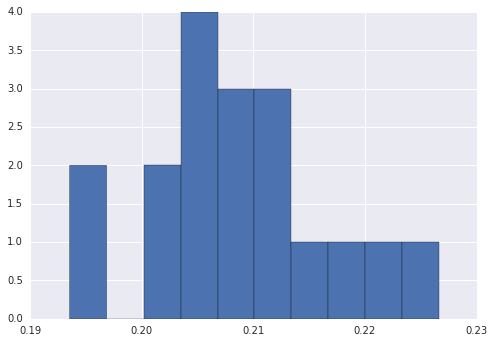

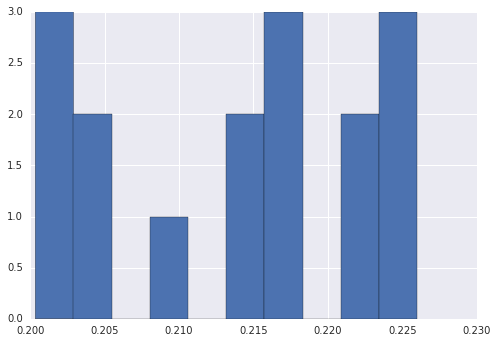

In [151]:
plt.hist([x['pct.authors.by.pre.study.right'] for x in list(day_counts.values()) if x['TREAT']=="arm_1"])
plt.show()
plt.hist([x['pct.authors.by.pre.study.right'] for x in list(day_counts.values()) if x['TREAT']=="arm_0"])
plt.show()

In [154]:
day_count_data[0]

{'TREAT': 'arm_1',
 'TREAT.day.id': 0,
 'day.type': 'special',
 'num.authors': 21288,
 'num.comments': 68557,
 'num.comments.removed': 2128,
 'pct.authors.by.pre.study.donald': 0.2400413378429162,
 'pct.authors.by.pre.study.left': 0.13749530251785044,
 'pct.authors.by.pre.study.politics': 0.077978203682826,
 'pct.authors.by.pre.study.right': 0.20297820368282601,
 'pct.comments.by.pre.study.donald': 0.2402088772845953,
 'pct.comments.by.pre.study.left': 0.13880420671849703,
 'pct.comments.by.pre.study.politics': 0.08016686844523535,
 'pct.comments.by.pre.study.right': 0.20126318246130956,
 'valid.treatment': True}

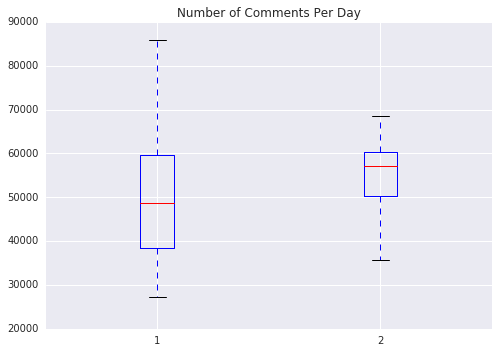

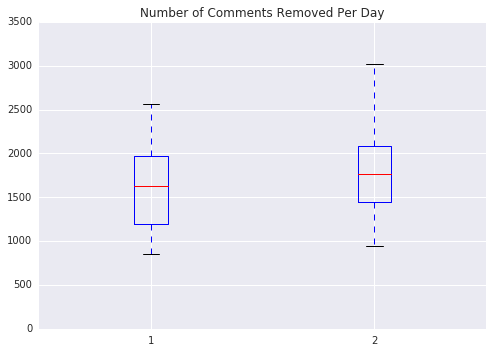

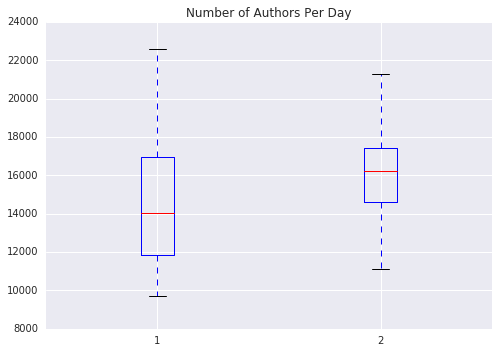

In [164]:
plt.boxplot([[x['num.comments'] for x in day_count_data if x['TREAT']=='arm_0'], 
             [x['num.comments'] for x in day_count_data if x['TREAT']=='arm_1']])
plt.title("Number of Comments Per Day")
plt.show()

plt.boxplot([[x['num.comments.removed'] for x in day_count_data if x['TREAT']=='arm_0'], 
             [x['num.comments.removed'] for x in day_count_data if x['TREAT']=='arm_1']])
plt.title("Number of Comments Removed Per Day")
plt.show()

plt.boxplot([[x['num.authors'] for x in day_count_data if x['TREAT']=='arm_0'], 
             [x['num.authors'] for x in day_count_data if x['TREAT']=='arm_1']])
plt.title("Number of Authors Per Day")

### Quick models of Day Totals

In [190]:
pd.DataFrame(day_count_data).to_csv("outputs/day.count.with.partisanship.11.2017.csv")

# Old Code
### Step two: collect data on experiment actions and associate them with snapshots

In [ ]:
# actions = []
# for row in db_engine.execute(text("""\
#     select *
#     FROM experiment_actions 
#     WHERE experiment_id=9 AND action='Intervention' ORDER BY created_at ASC;
#     """)):
#     action = {}
#     for key, value in row.items():
#         if(key!="metadata_json"):
#             action[key] = value
#     metadata = json.loads(row['metadata_json'])
#     for key, value in metadata.items():
#         action[key] = value
        
#     actions.append(action)

### Step three: Associate snapshots with experiment actions

In [ ]:
# current_action_index = 0
# current_action = actions[current_action_index]
# snapshot_count = 0 
# early_snapshots = []

# snapshot_counts = defaultdict(int)

# for snapshot in comment_snapshots:
#     while((snapshot['et_created_at'] - current_action['created_at']).total_seconds() > 86400 ):
#         current_action_index += 1
#         current_action = actions[current_action_index]
#         print("Moving to action at {0} after {1} snapshots".format(current_action['created_at'], snapshot_count))
#         snapshot_count = 0 
    
    
#     snapshot['arm'] = current_action['arm']
#     snapshot['condition'] = current_action['condition']
#     snapshot['elapsed_minutes'] = (snapshot['et_created_at'] - snapshot['created_at']).total_seconds() / 60 
#     snapshot['snap_num'] = snapshot_counts[snapshot['experiment_thing_id']]
#     snapshot_counts[snapshot['experiment_thing_id']] += 1
#     if(snapshot['elapsed_minutes']) <61:
#         early_snapshots.append(snapshot)
#     snapshot_count += 1

### Histogram to confirm that the rough data assignment was successful

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
plt.hist([x['elapsed_minutes'] for x in comment_snapshots], bins=200)
plt.title("Elapsed Minutes")
plt.show()

plt.hist([x['snap_num'] for x in comment_snapshots], bins=35)
plt.title("Snapshot Num")
plt.show()

# plt.scatter([x['snap_num'] for x in early_snapshots], [x['elapsed_minutes'] for x in early_snapshots])
# plt.title("Elapsed Minutes over Snapshot Num")
# plt.show()


### Now create a dataframe

In [ ]:
snapshot_df = pd.DataFrame(comment_snapshots)

In [ ]:
#print(snapshot_df.downs.describe())
#print(snapshot_df.ups.describe())
#print(snapshot_df.describe())
snapshot_df[(snapshot_df['elapsed_minutes'] <=30) & (snapshot_df['elapsed_minutes'] >=25)].describe()


In [ ]:
result = smf.ols(formula = "score ~ arm + arm:condition", 
                 data = snapshot_df[(snapshot_df['elapsed_minutes'] <=180) & (snapshot_df['elapsed_minutes'] >=175)]).fit()
print(result.summary())

In [ ]:
result = smf.ols(formula = "score ~ arm", 
                 data = snapshot_df[(snapshot_df['elapsed_minutes'] <=180) & (snapshot_df['elapsed_minutes'] >=175)]).fit()
print(result.summary())

In [ ]:
#dir(result.params)
result.params['Intercept']

12224